<a href="https://colab.research.google.com/github/Simardeep27/Interpretation_Methods/blob/main/Aerofoil_noise_for_Simardeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install git+https://github.com/Effective-Quadratures/equadratures.git@develop



import numpy as np
import equadratures as eq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import string
import matplotlib.transforms
import matplotlib.ticker as ticker
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import RandomForestRegressor
import scipy as sp

  Cloning https://github.com/Effective-Quadratures/equadratures.git (to revision develop) to /tmp/pip-req-build-8n50guew
  Running command git clone -q https://github.com/Effective-Quadratures/equadratures.git /tmp/pip-req-build-8n50guew
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for equadratures: filename=equadratures-9.1.0-cp37-none-any.whl size=132833 sha256=689c0ac9b085dbf1cc0083fcf9638d6cd9cc2d626d7a5dbfb0bb66db40c705cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-nk6kpn7b/wheels/83/29/c9/85b4dae59060f70c5a2f0eec5f51a665061d2393108b74db65
Successfully built equadratures


In [3]:
!pip install alibi
import alibi
from alibi import *

     |████████████████████████████████| 317kB 9.3MB/s 
     |████████████████████████████████| 28.0MB 164kB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052145 sha256=90522350c4593edca8f27a00a8e5d16ce523ff283b070a10ca74c4af2e32cf55
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built spacy-lookups-data


In [4]:
# Usind pandas to import the dataset
Aerofoil_num=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat', sep="\t", names = ['Freq','AOA','ChordLength','FSV','Suction','SPL'])


Aerofoil_num.head()
#Our data consists of 6 features, where 'SPL' is our target feature.

,Freq,AOA,ChordLength,FSV,Suction,SPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [5]:
Aerofoil_num.corr()

,Freq,AOA,ChordLength,FSV,Suction,SPL
Freq,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
AOA,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
ChordLength,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
FSV,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
Suction,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
SPL,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


In [6]:
y=Aerofoil_num['SPL']
Aerofoil_num.drop('SPL',inplace=True,axis=1)
X=Aerofoil_num
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

# **Linear Regression** 

In [7]:
modelLinear=LinearRegression().fit(X_train,y_train)
y_pred=modelLinear.predict(X_test)
print('R2 score: ',r2_score(y_test,y_pred))
#Linear_reg does not provide a good r2_score hence using other models

R2 score:  0.4489987254275475


In [8]:
#Using PolynomialFeatures for finding the best fit for our data on different order values.
order=[1,2,3,4,5,6,7]
best_score=0
best_degree=0
for degrees in order:
    poly=PolynomialFeatures(degree=degrees)
    X_train_poly=poly.fit_transform(X_train)
    X_test_poly=poly.fit_transform(X_test)
    mod=LinearRegression().fit(X_train_poly,y_train)
    y_pred=mod.predict(X_test_poly)
    score=r2_score(y_test,y_pred)
    if score>best_score:
        best_score=score
        best_degree=degrees

# best_degree=3, best_score=0.74
poly=PolynomialFeatures(degree=best_degree)
X_train_poly=poly.fit_transform(X_train)
X_test_poly=poly.fit_transform(X_test)
mod=LinearRegression().fit(X_train_poly,y_train)
y_pred=mod.predict(X_test_poly)
score=r2_score(y_test,y_pred)

# Making a key,value pair dictionary with feature_names as our key and the coefficient as our value.
coefficients={}
for i,val in enumerate(poly.get_feature_names(X.columns)):
    coefficients[val]=mod.coef_[i]

print(coefficients)

{'1': 0.015196883526279535, 'Freq': 0.0036111431571313937, 'AOA': 0.005223375305199209, 'ChordLength': 1.6675381239448944e-05, 'FSV': -0.00044503209462974354, 'Suction': -1.126856090379572e-05, 'Freq^2': -1.184523944779264e-06, 'Freq AOA': -0.0009267061450095401, 'Freq ChordLength': -0.038163569005741325, 'Freq FSV': 0.00021921033002105035, 'Freq Suction': -0.010153548581692769, 'AOA^2': 0.017639532310188742, 'AOA ChordLength': -0.0008406362390610947, 'AOA FSV': 0.03424268245776451, 'AOA Suction': 2.1103953111478092e-05, 'ChordLength^2': 6.71128672181371e-05, 'ChordLength FSV': -0.000704169302546796, 'ChordLength Suction': -2.0085470481206555e-06, 'FSV^2': -0.013775252129499743, 'FSV Suction': -0.00027871996572737516, 'Suction^2': 1.707024543964262e-06, 'Freq^3': 8.878001530309711e-11, 'Freq^2 AOA': 1.0638938983750118e-07, 'Freq^2 ChordLength': 3.1820540631644247e-06, 'Freq^2 FSV': -1.0209594009372624e-08, 'Freq^2 Suction': -9.831187331919027e-05, 'Freq AOA^2': 4.85981298151422e-05, 'F

# TODO: Construct g(x) using the dictionary use to calc. sobol indices for ordinary least sqaure model.

In [9]:
order_param=9
Freq=eq.Parameter(distribution="Uniform",lower=200.,upper=20000.,order=order_param)
AoA=eq.Parameter(distribution="Uniform",lower=0.,upper=22.2,order=order_param)
ChordLength=eq.Parameter(distribution="Uniform",lower=0.025,upper=0.304,order=order_param)
FSV=eq.Parameter(distribution="Uniform",lower=31.70,upper=71.30,order=order_param)
Suction=eq.Parameter(distribution="Uniform",lower=0.0004,upper=0.0584,order=order_param)
parameters = [Freq,AoA,ChordLength,FSV,Suction]

# Define basis
basis = eq.Basis('total-order')

In [10]:
# Create eq polynomial with ordinary least squares (OLS)  - R2=0.74 with order 4
poly = eq.Poly(parameters=parameters, basis=basis, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': X_train.to_numpy(), 'sample-outputs': y_train.to_numpy()})
poly.set_model()
y_pred_train = poly.get_polyfit(X_train.to_numpy())
y_pred_test  = poly.get_polyfit(X_test.to_numpy())
r2_train = r2_score(y_train.to_numpy(),y_pred_train)
r2_test = r2_score(y_test.to_numpy(),y_pred_test)
print('Training R2: %.2f' % r2_train)
print('Test R2: %.2f' % r2_test)

Training R2: 0.98
Test R2: -4139693.55


In [11]:
# Create eq polynomial with elastic net - R2=0.84 with order 9
regpoly = eq.Poly(parameters=parameters, basis=basis, method='elastic-net', 
               solver_args = {'alpha':1.0,'crit':'AIC'},\
              sampling_args= {'mesh': 'user-defined', 'sample-points': X_train.to_numpy(), 'sample-outputs': y_train.to_numpy()})
regpoly.set_model()
y_pred_train = regpoly.get_polyfit(X_train.to_numpy())
y_pred_test  = regpoly.get_polyfit(X_test.to_numpy())
r2_train = r2_score(y_train.to_numpy(),y_pred_train)
r2_test = r2_score(y_test.to_numpy(),y_pred_test)
print('Training R2: %.2f' % r2_train)
print('Test R2: %.2f' % r2_test)

Training R2: 0.84
Test R2: 0.79


In [12]:
regpoly.get_coefficients()

array([116.3329378 ,  -1.72706746,   0.9629897 , ...,   0.        ,
         0.        ,   0.        ])

In [13]:
def plot_Sobol(Polynomial,order=1,save=False,show=True,return_figure=False,parameters=None):
  if (parameters)==None:
        parameters_x=[r'$S_%d$' %i  for i in range(0,Polynomial.dimensions)]
  else:  
        parameters_x=[i for i in parameters]
  sobol_indices=Polynomial.get_sobol_indices(order)
  fig=plt.figure(figsize=(9,9))
  ax=plt.subplot()
  if order==1:
      x=0
      for i in range(len(parameters_x)):
        plt.bar(x,sobol_indices[(i,)],color='green')
        x=x+1
      plt.xlabel(r'Parameters')
      plt.ylabel(r'Sobol Indices for order {}'.format(order))
      xticks=[]
      xticks.append(" ")
      for i in range(len(parameters_x)):
        xticks.append(parameters_x[i])
        ax.set_xticklabels(xticks,Fontsize=20,rotation=45)
  elif order==2:
    x=0
    for i in range(len(parameters_x)):
      for j in range(i+1,len(parameters_x)):
        plt.bar(x,sobol_indices[(i,j)],color='green')
        x=x+1
    plt.xlabel(r'Parameters')
    plt.ylabel(r'Sobol Indices for order {}'.format(order))
    xticks=[]
    for i in range(0,len(parameters_x)):
      for j in range(i+1,len(parameters_x)):
        string=parameters_x[i] +' ' +parameters_x[j]
        xticks.append(string)
    ax.set_xticks(sp.arange(len(sobol_indices)))
    ax.set_xticklabels(xticks)
    plt.setp(ax.xaxis.get_majorticklabels(),rotation=45,Fontsize=10)
  elif order==3:
    x=0
    for i in range(len(parameters_x)):
      for j in range(i+1,len(parameters_x)):
        for k in range(j+1,len(parameters_x)):
          plt.bar(x,sobol_indices[(i,j,k)],color='green')
          x=x+1
    plt.xlabel(r'Parameters')
    plt.ylabel(r'Sobol Indices for order {}'.format(order))
    xticks=[]
    for i in range(len(parameters_x)):
      for j in range(i+1,len(parameters_x)):
        for k in range(j+1,len(parameters_x)):
          string=parameters_x[i]+' '+parameters_x[j]+' '+parameters_x[k]
          xticks.append(string)
    ax.set_xticks(sp.arange(len(sobol_indices)))
    ax.set_xticklabels(xticks,Fontsize=10,rotation=45)
  if save:
      plt.savefig('sobol_plot.png', dpi=140, bbox_inches='tight')
  if show:
      plt.show()
  if return_figure:
      return fig,ax


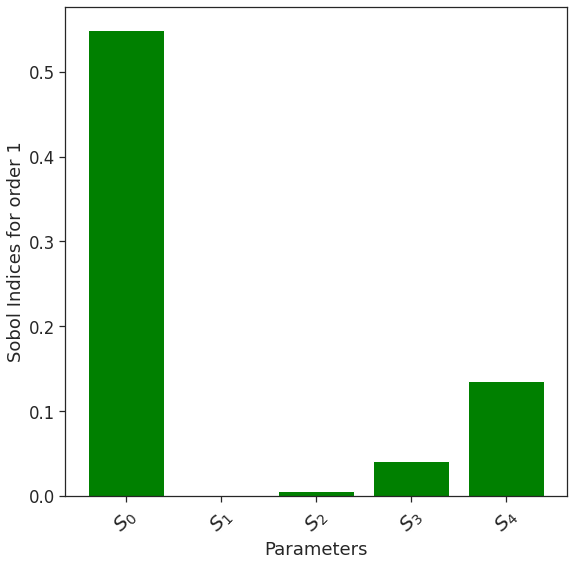

In [14]:
plot_Sobol(regpoly)

In [15]:
RFmodel=RandomForestRegressor(n_estimators=8)
RFmodel.fit(X_train,np.array(y_train).reshape(-1,1))
y_pred=RFmodel.predict(X_test)
print("score: ",r2_score(y_test,y_pred))

score:  0.9181203701768561


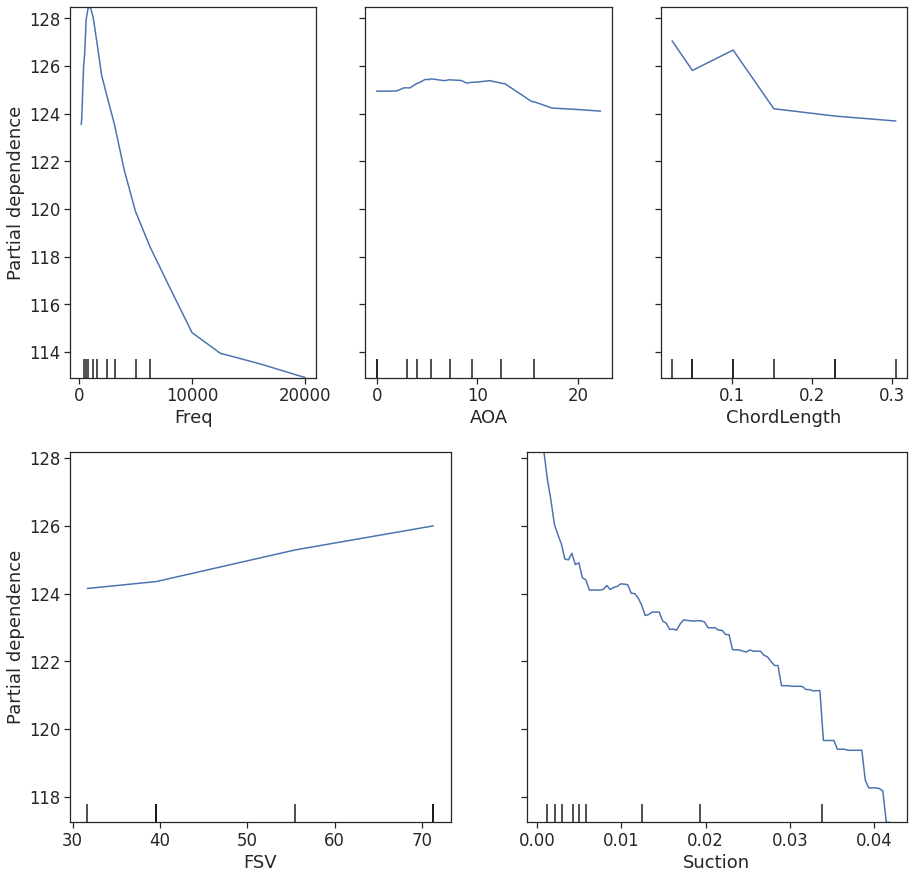

In [16]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(15,15))
plot_partial_dependence(RFmodel,X,[0,1,2],ax=ax1)
plot_partial_dependence(RFmodel,X,[3,4],ax=ax2)

TypeError: ignored

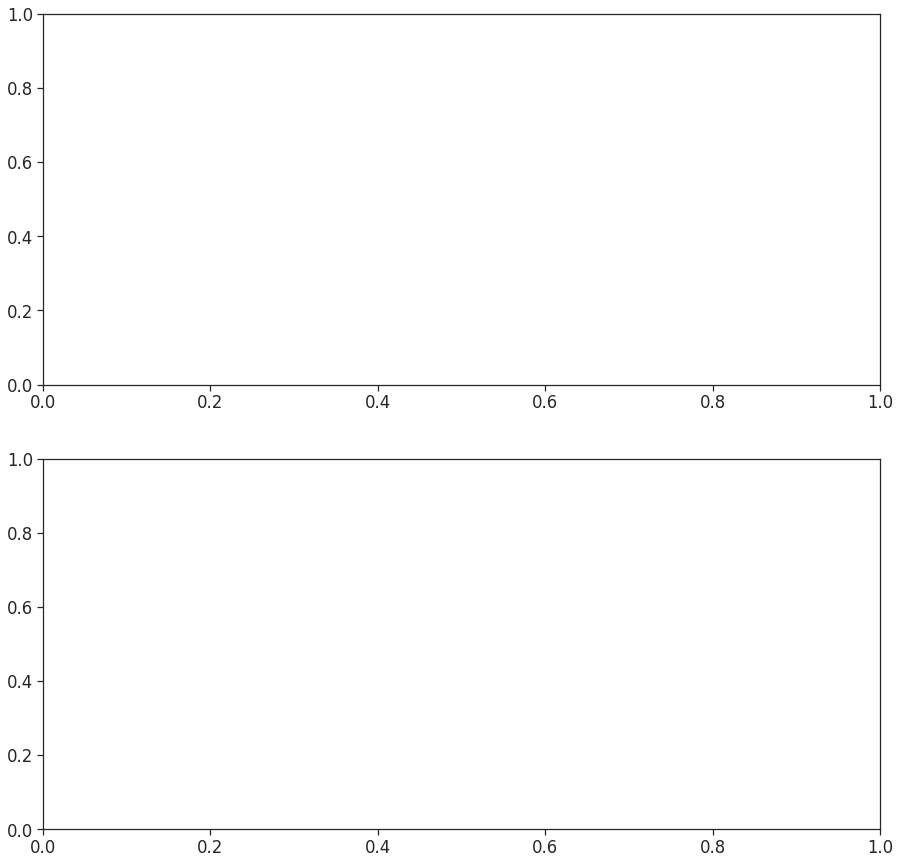

In [29]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(15,15))
plot_partial_dependence(RFmodel,X,[0,1,2],ax=ax1,kind='individual')
plot_partial_dependence(RFmodel,X,[3,4],ax=ax2,kind='individual')
plot_partial_dependence()

# Accumulated Local Effects

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97b6486a10>,
      dtype=object)

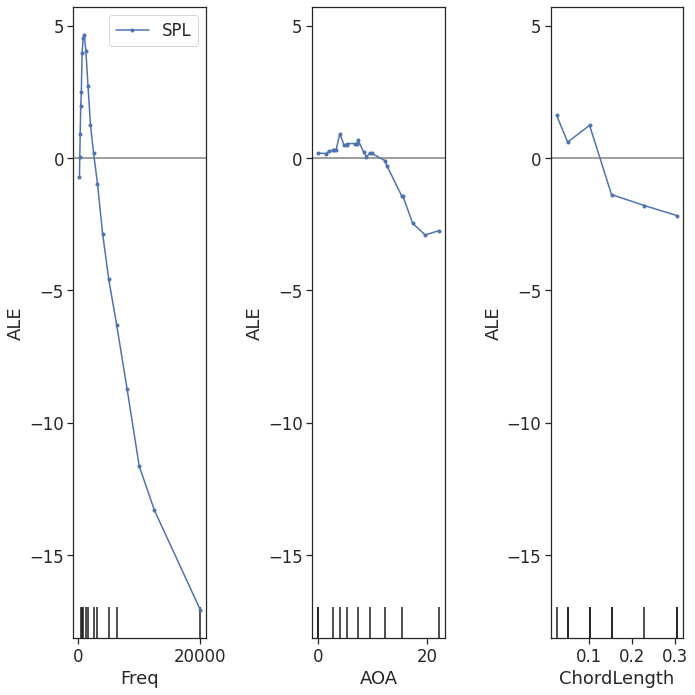

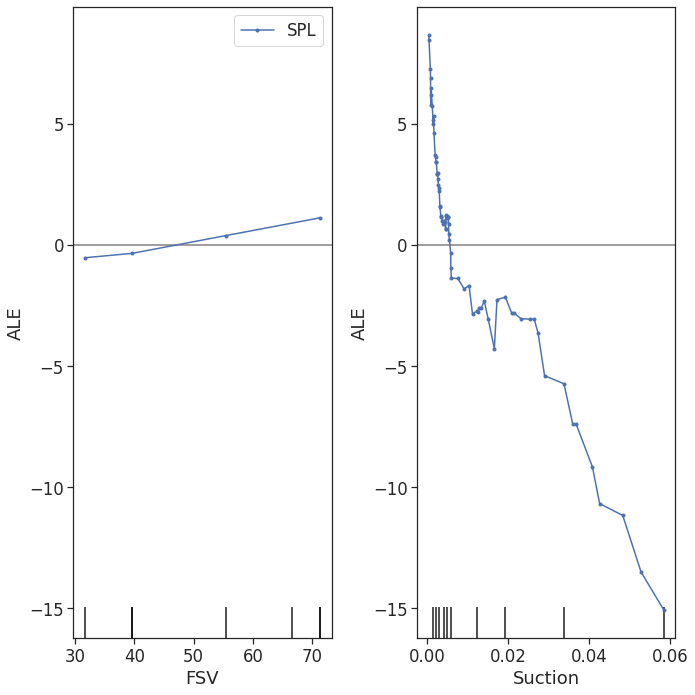

In [17]:
rf=alibi.explainers.ALE(RFmodel.predict,feature_names=X_train.columns,target_names=["SPL"])
rf_exp=rf.explain(np.array(X_train))
alibi.explainers.plot_ale(rf_exp,fig_kw={"figwidth":10,"figheight":10},features=['Freq','AOA','ChordLength'])
alibi.explainers.plot_ale(rf_exp,fig_kw={"figwidth":10,"figheight":10},features=['FSV','Suction'])

### The ALE plot shows that the parameter frequency and Suction has strong effect on the prediction, 
##### Note that there is a difference between the Partial Dependence plot and ALE plot for parameters Suction and AOA which is due to high correlation between them.